In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

from keras import layers, regularizers
import cv2
from keras import backend as K
import os
import glob
import re
import gc
# from google.colab.patches import cv2_imshow
from keras.models import Sequential, Model, load_model
from keras.layers import (
    Dense,
    Dropout,
    Conv2D,
    Reshape,
    Input,
)
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from kerastuner.tuners import RandomSearch

In [2]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print(physical_devices)
# if physical_devices:
#   tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Cell 2: Define Constants and Custom Loss
HEIGHT = 64
WIDTH = 64

def weighted_mse(yTrue, yPred):
    ones = K.ones_like(yTrue[0, :])
    idx = K.cumsum(ones)
    return K.mean((1 / idx) * K.square(yTrue - yPred))

In [4]:
# Cell 3: Image Manipulation Functions

# rotate image by a given angle
def rotateImage(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    return cv2.warpAffine(image, M, (nW, nH))

In [5]:
# Cell 4: Data Split Function
def splitter():
    train_files = []
    validation_files = []
    test_files = []
    folders = glob.glob("data/*")
    train_pca = []
    print(folders)
    for folder in folders:
        folder_files = [x for x in os.listdir(folder) if x.endswith(".jpg")]

        for file in folder_files:
            csv_file = file.replace(".jpg", ".csv")
            file = os.path.join(folder, file)

            try:
                csv_file = os.path.join(folder, csv_file)
                csv_file = pd.read_csv(csv_file)
                if csv_file.shape[0] == 205:

                    prob = np.random.random()
                    if prob < 0.02:
                        test_files.append(file)
                    elif 0.02< prob <0.12:
                        validation_files.append(file)
                    else:
                        train_files.append(file)
            except:
                continue

    print(len(train_files))
    print(len(validation_files))
    print(len(test_files))
    return train_files, test_files, validation_files

train_files, test_files, validation_files = splitter()

[]
0
0
0


In [6]:
# Cell 5: PCA Function
def PCA_Done(train_files):
    data = np.zeros((len(train_files), 201))

    for i, file in enumerate(train_files):
        label_name = file.replace(".jpg", ".csv")
        if os.path.exists(label_name):
            label_file = pd.read_csv(
                label_name, skiprows=[0, 1, 2, 3, 4], names=["freq", "values"]
            )
            data[i, :] = label_file["values"].astype(float)

    # using the training files fit pca
    pca = PCA(n_components=20)
    pca.fit(data)
    explained_var = pca.explained_variance_ratio_
    print(explained_var)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(explained_var)), explained_var, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(len(explained_var)), np.cumsum(explained_var), where='mid', label='cumulative explained variance')
    plt.xlabel('Principal components')
    plt.ylabel('Explained variance ratio')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    print(sum(pca.explained_variance_ratio_))
    return pca
pca = PCA_Done(train_files)


ValueError: Found array with 0 sample(s) (shape=(0, 201)) while a minimum of 1 is required by PCA.

In [ ]:
# Cell 6: Batch Generator
def batch_generator(pca, X, batch_size=64):
    while True:
        # Select files (paths/indices) for the batch
        batch_paths = np.random.randint(low=0, high=len(X), size=batch_size)

        images = []
        props = []
        batch_label = []

        # Read in each input, perform preprocessing and get labels
        for input_path_index in batch_paths:
            file = X[input_path_index]

            img = cv2.imread(file, 0)

            folder = os.path.split(os.path.split(file)[0])[1]
            if folder == "0d65h" or folder == "0d75h":
                angle = np.random.randint(0, 360)
                img = rotateImage(img, angle)
            img = cv2.resize(img, (HEIGHT, WIDTH))

            img = img / 255
            img = img.reshape(img.shape[0], img.shape[1], 1)
            prop = re.findall("\d+", folder)
            prop = [int(x) for x in prop]

            prop[0] = prop[0] / 60
            prop[1] = prop[1] / 75

            prop1 = np.full((HEIGHT, WIDTH, 1), prop[0])
            prop2 = np.full((HEIGHT, WIDTH, 1), prop[1])

            props = np.concatenate((prop1, prop2), axis=2)
            # combine properties to images as additional channels
            img = np.concatenate((img, props), axis=2)
            images.append(img)
            # props.append(prop)
            label_name = file.replace(".jpg", ".csv")

            label_file = pd.read_csv(
                label_name, skiprows=[0, 1, 2, 3, 4], names=["freq", "values"]
            )
            label_file["values"] = label_file["values"].astype(float)
            label = label_file["values"].values
            label = pca.transform(label.reshape(1, -1)).reshape(-1,)


            batch_label.append(label)

        batch_x = np.array(images)
        batch_y = np.array(batch_label)

        yield (batch_x, batch_y)
train_gen = batch_generator(pca, train_files)
valid_gen = batch_generator(pca, validation_files, batch_size=8)
test_gen = batch_generator(pca, test_files, 1)

In [ ]:
# Cell 7: Model Building Function
def build_vit_model(image_size, num_classes, num_heads=4, num_transformer_layers=4):
    inputs = layers.Input(shape=(image_size, image_size, 3))
    # Convert image to patches
    patches = layers.Conv2D(filters=64, kernel_size=(8, 8), strides=(8, 8))(inputs)
    patches = layers.Reshape((64, 64))(patches)
    # Add Dropout
    patches = layers.Dropout(0.2)(patches)

    # Positional encoding
    pos_enc = layers.Embedding(input_dim=64, output_dim=64)(
        tf.range(start=0, limit=64, delta=1)
    )
    patches += pos_enc

    # Transformer layers
    for _ in range(num_transformer_layers):
        # Multi-head attention
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)(
            patches, patches
        )
        patches = layers.LayerNormalization()(patches + attn_output)

        # Feed-forward network
        ffn = layers.Dense(128, activation="relu")(patches)
        ffn = layers.Dense(64)(ffn)
        # add dropout
        ffn = layers.Dropout(0.2)(ffn)

        patches = layers.LayerNormalization()(patches)
        
                                              

    output = layers.Dense(20, activation="linear")(patches[:, 0, :])

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

'''
def build_vit_model(image_size, num_classes, num_heads=4, num_transformer_layers=4):
    model = Sequential()


'''

model = build_vit_model(64, 1)  # Replace 256 with your actual image size
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=weighted_mse,
    metrics=["mae"],
)
print(model.summary())
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "iteration_3.h5", save_weights_only=True, save_best_only=True, mode="min"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.8,
        patience=100,
        min_lr=1e-5,
        min_delta=0.000001,
        verbose=1,
        mode="min",
    ),
    tf.keras.callbacks.
]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 64)     12352       ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 64, 64)       0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 64, 64)       0           ['reshape[0][0]']                
                                                                                              

In [ ]:

# CODE FOR HYPERPARAMETERS TUNING

# from kerastuner.tuners import RandomSearch

# def build_model(hp):
#     model = build_vit_model(
#         image_size=hp.Int('image_size', min_value=32, max_value=256, step=32),
#         num_classes=10,
#         num_heads=hp.Int('num_heads', min_value=2, max_value=8, step=2),
#         num_transformer_layers=hp.Int('num_transformer_layers', min_value=1, max_value=8, step=1)
#     )
#     model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=5,  # number of different hyperparameter configurations to try
#     executions_per_trial=3,  # number of times to train each model, to average out the metrics
#     directory='random_search',
#     project_name='vit'
# )

# tuner.search(train_gen, epochs=5, validation_data=(valid_gen))


In [ ]:
# best_model = tuner.get_best_models(num_models=1)[0]
# best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Cell 8: Prediction Function
def predict():
    for file in test_files[:25]:
        img = cv2.imread(file, 0)

        folder = os.path.split(os.path.split(file)[0])[1]
        if folder == "0d65h" or folder == "0d75h":
            angle = np.random.randint(0, 360)
            img = rotateImage(img, angle)
        img = cv2.resize(img, (HEIGHT, WIDTH))
        img = img.reshape(img.shape[0], img.shape[1], 1)
        img = img / 255
        prop = re.findall("\d+", folder)
        prop = [int(x) for x in prop]
        prop = np.array(prop)
        prop[0] = prop[0] / 60
        prop[1] = prop[1] / 75
        prop1 = np.full((HEIGHT, WIDTH, 1), prop[0])
        prop2 = np.full((HEIGHT, WIDTH, 1), prop[1])
        props = np.concatenate((prop1, prop2), axis=2)
        img = np.concatenate((img, props), axis=2)
        img = img.reshape(-1, img.shape[0], img.shape[1], img.shape[2])
        label_name = file.replace(".jpg", ".csv")

        label_file = pd.read_csv(
            label_name, skiprows=[0, 1, 2, 3, 4], names=["freq", "values"]
        )
        label_file["values"] = label_file["values"].astype(float)
        label = label_file["values"].values

        pred = model.predict(img)
        # print(pred)
        predictions = pca.inverse_transform(pred).reshape(-1)
        # pred = np.array(pred)

        # predictions = pca.inverse_transform(pred[0])
        # pred = scale.inverse_transform(predictions)
        label_file["pred_values"] = predictions
        print(label_file["pred_values"].shape)
        plt.ylim(-1,1)
        plt.plot(predictions)
        plt.plot(label)
        plt.legend(["Predictions", "Actual_Values"])
        plt.show()

K.clear_session()
gc.collect()


31374

In [ ]:
# model.load_weights('best_model_v2.h5')

history = model.fit(
    train_gen,
    epochs=1500,
    verbose=1,
    batch_size=32,
    validation_data=valid_gen,
    validation_steps=len(validation_files) // 8,
    steps_per_epoch=len(train_files) // 32,
    callbacks=callbacks,
)

model.save_weights('iteration_3_weights.h5')

model.save('iteration_3_model.h5')


Epoch 1/1500
92/92 [==============================] - 36s 371ms/step - loss: 0.0883 - mae: 0.4024 - val_loss: 0.0615 - val_mae: 0.1805 - lr: 1.0000e-04
Epoch 2/1500
92/92 [==============================] - 32s 351ms/step - loss: 0.0566 - mae: 0.2359 - val_loss: 0.0527 - val_mae: 0.1587 - lr: 1.0000e-04
Epoch 3/1500
92/92 [==============================] - 30s 333ms/step - loss: 0.0535 - mae: 0.2076 - val_loss: 0.0577 - val_mae: 0.1652 - lr: 1.0000e-04
Epoch 4/1500
92/92 [==============================] - 29s 320ms/step - loss: 0.0488 - mae: 0.1945 - val_loss: 0.0536 - val_mae: 0.1585 - lr: 1.0000e-04
Epoch 5/1500
92/92 [==============================] - 29s 315ms/step - loss: 0.0353 - mae: 0.2057 - val_loss: 0.0272 - val_mae: 0.1650 - lr: 1.0000e-04
Epoch 6/1500
92/92 [==============================] - 29s 316ms/step - loss: 0.0207 - mae: 0.1828 - val_loss: 0.0287 - val_mae: 0.1557 - lr: 1.0000e-04
Epoch 7/1500
92/92 [==============================] - 27s 299ms/step - loss: 0.0183 - ma

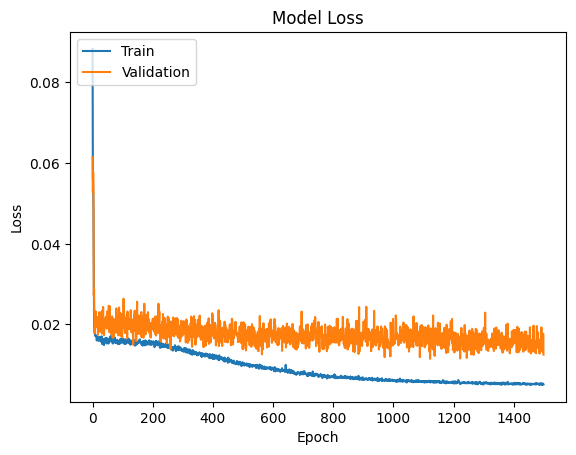

In [ ]:
# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# For loading the model if program has been terminated

# model1 = load_model('iteration_3_model.h5',custom_objects={"weighted_mse" : weighted_mse})
# print(model1.summary())

print(f"Test Loss: {model.evaluate(test_gen, steps=len(test_files))}")



67/67 [==============================] - 2s 30ms/step - loss: 0.0119 - mae: 0.1171
Test Loss: [0.011876218020915985, 0.11712530255317688]


In [ ]:
predict()


NameError: name 'predict' is not defined